In [1]:
import sys
from docplex.cp.model import *
import cplex
import pandas as pd
import numpy as np

In [2]:
#this is the instruction for using the cloud service for cplex url and key could be replace by your own account one
url = "https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/"
key = "..."

In [3]:
dpath = '...'
df1 = pd.read_csv(dpath +"process_schedule.csv")
df2 = pd.read_csv(dpath +"process_dict.csv")

In [4]:
# Number of batches simulated
NbBatches = 3;
Batches = range(NbBatches)
mdl1 = CpoModel()

In [5]:
# Define TankNames
TankNames = df1['TankNames'].tolist()

TankNames = list(set(TankNames))

In [6]:
# Define TaskNames
TaskNames = df2['Tasknames'].tolist()

In [7]:
len(TaskNames)

86

In [8]:
#Define Duration
Duration = df2['Duration'].tolist()

In [9]:
len(Duration)

86

In [10]:
#Define Tanks & Tasks
Tanks = dict(zip(df2['Tasknames'],df2['TankNames']))

In [11]:
len(Tanks)

86

In [12]:
# Define precedences

Precedences = set()


pre = df1['Predecessor'].tolist()

for i in range(len(pre)):
    if 'None' in pre:
        pre.remove('None')
        
tempTask = list()

for i in range(len(df1)):
    if df1.iat[i,3] != "None":
        tempTask.append(df1.iat[i,1])


for k in range(len(tempTask)):
    Precedences.add((pre[k],tempTask[k]))

In [13]:
len(Precedences)

113

In [14]:
# Define Maintenance Break
Breaks = {
    "TK3606": [(50,55),(155,160)],
    "TK4502":[(50,55),(155,160)],
    "TK3406":[(85,90),(200,205)],
    "TK4801A":[(85,90),(200,205)],
    "TK4701":[(85,90),(200,205)],
    "TK3503":[(85,90),(200,205)],
    "TK3603":[(50,55),(155,160)],
    "TK4901":[(50,55),(155,160)],
    "TK3407":[(50,55),(155,160)],
    "TK4803A":[(85,90),(200,205)],
    "TK3605":[(50,55),(155,160)],
    "TK4802A":[(80,90),(200,210)]   
}

In [15]:
from collections import namedtuple
Break = namedtuple('Break', ['start', 'end'])

In [16]:
# Define Calendar
Calendar = {}
mymax = max(max(v for k,v in Breaks[w]) for w in TankNames)
for w in TankNames:
    step = CpoStepFunction()
    step.set_value(0, mymax, 100)
    for b in Breaks[w]:
        t = Break(*b)
        step.set_value(t.start, t.end, 0)
    Calendar[w] = step

In [17]:
Calendar

{'TK3605': <docplex.cp.function.CpoStepFunction at 0x25bcd02bf48>,
 'TK4502': <docplex.cp.function.CpoStepFunction at 0x25bcd090048>,
 'TK4801A': <docplex.cp.function.CpoStepFunction at 0x25bcd0900c8>,
 'TK4701': <docplex.cp.function.CpoStepFunction at 0x25bcd090148>,
 'TK3606': <docplex.cp.function.CpoStepFunction at 0x25bcd0901c8>,
 'TK4901': <docplex.cp.function.CpoStepFunction at 0x25bcd090248>,
 'TK3407': <docplex.cp.function.CpoStepFunction at 0x25bcd0902c8>,
 'TK4803A': <docplex.cp.function.CpoStepFunction at 0x25bcd090348>,
 'TK3406': <docplex.cp.function.CpoStepFunction at 0x25bcd0903c8>,
 'TK3603': <docplex.cp.function.CpoStepFunction at 0x25bcd090448>,
 'TK4802A': <docplex.cp.function.CpoStepFunction at 0x25bcd0904c8>,
 'TK3503': <docplex.cp.function.CpoStepFunction at 0x25bcd090548>}

In [18]:
itvs = {}
for b in Batches:
    for i,t in enumerate(TaskNames):
        _name = str(b) + "_" + str(t)
        itvs[(b,t)] = mdl1.interval_var(size=Duration[i],intensity=Calendar[Tanks[t]],name=_name)    

In [19]:
itvs

{(0, '1UO1_A'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd0907c8>,
 (0, '1UO1_B'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090848>,
 (0, '1UO1_C'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd0908c8>,
 (0, '1UO2_A'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090948>,
 (0, '1UO2_B'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd0909c8>,
 (0, '1UO3_A'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090a48>,
 (0, '1UO3_B'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090ac8>,
 (0, '1UO3_C'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090b48>,
 (0, '1UO3_D'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090bc8>,
 (0, '1UO4_A'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090c48>,
 (0, '1UO5_A'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090cc8>,
 (0, '1UO5_B'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090d48>,
 (0, '1UO5_C'): <docplex.cp.expression.CpoIntervalVar at 0x25bcd090dc8>,
 (0, '1UO5_D'): <docplex.cp.expression.CpoIntervalV

In [20]:
for b in Batches:
    for p in Precedences:
        mdl1.add(mdl1.end_before_start(itvs[b,p[0]], itvs[b,p[1]]) )

In [21]:
for w in TankNames:
    mdl1.add( mdl1.no_overlap( [itvs[b,t] for b in Batches for t in TaskNames if Tanks[t]==w]  ) )

In [22]:
for b in Batches:
    for t in TaskNames:
        mdl1.add(mdl1.forbid_start(itvs[b,t], Calendar[Tanks[t]]))
        mdl1.add(mdl1.forbid_end (itvs[b,t], Calendar[Tanks[t]]))

In [23]:
mdl1.add( mdl1.minimize(mdl1.max(mdl1.end_of(itvs[b,'2UO16_A']) for b in Batches)))

In [24]:
# Solve the model
print("\nSolving model....")
msol1 = mdl1.solve(url=url, key=key, FailLimit=30000)
#msol1 = mdl1.solve(FailLimit=3000)
print("done")


Solving model....
done


In [25]:
msol1.get_objective_values()

(210,)

In [26]:
print(msol1.get_objective_values())

(210,)


In [27]:
print("Duration will be "+str( msol1.get_objective_values()[0]))

Duration will be 210


In [28]:
# Allocate tasks to Tanks
tasks = {w : [] for w in TankNames}
for k,v in Tanks.items():
    tasks[v].append(k)

types = {t : i for i,t in enumerate(TaskNames)}

<Figure size 432x288 with 0 Axes>

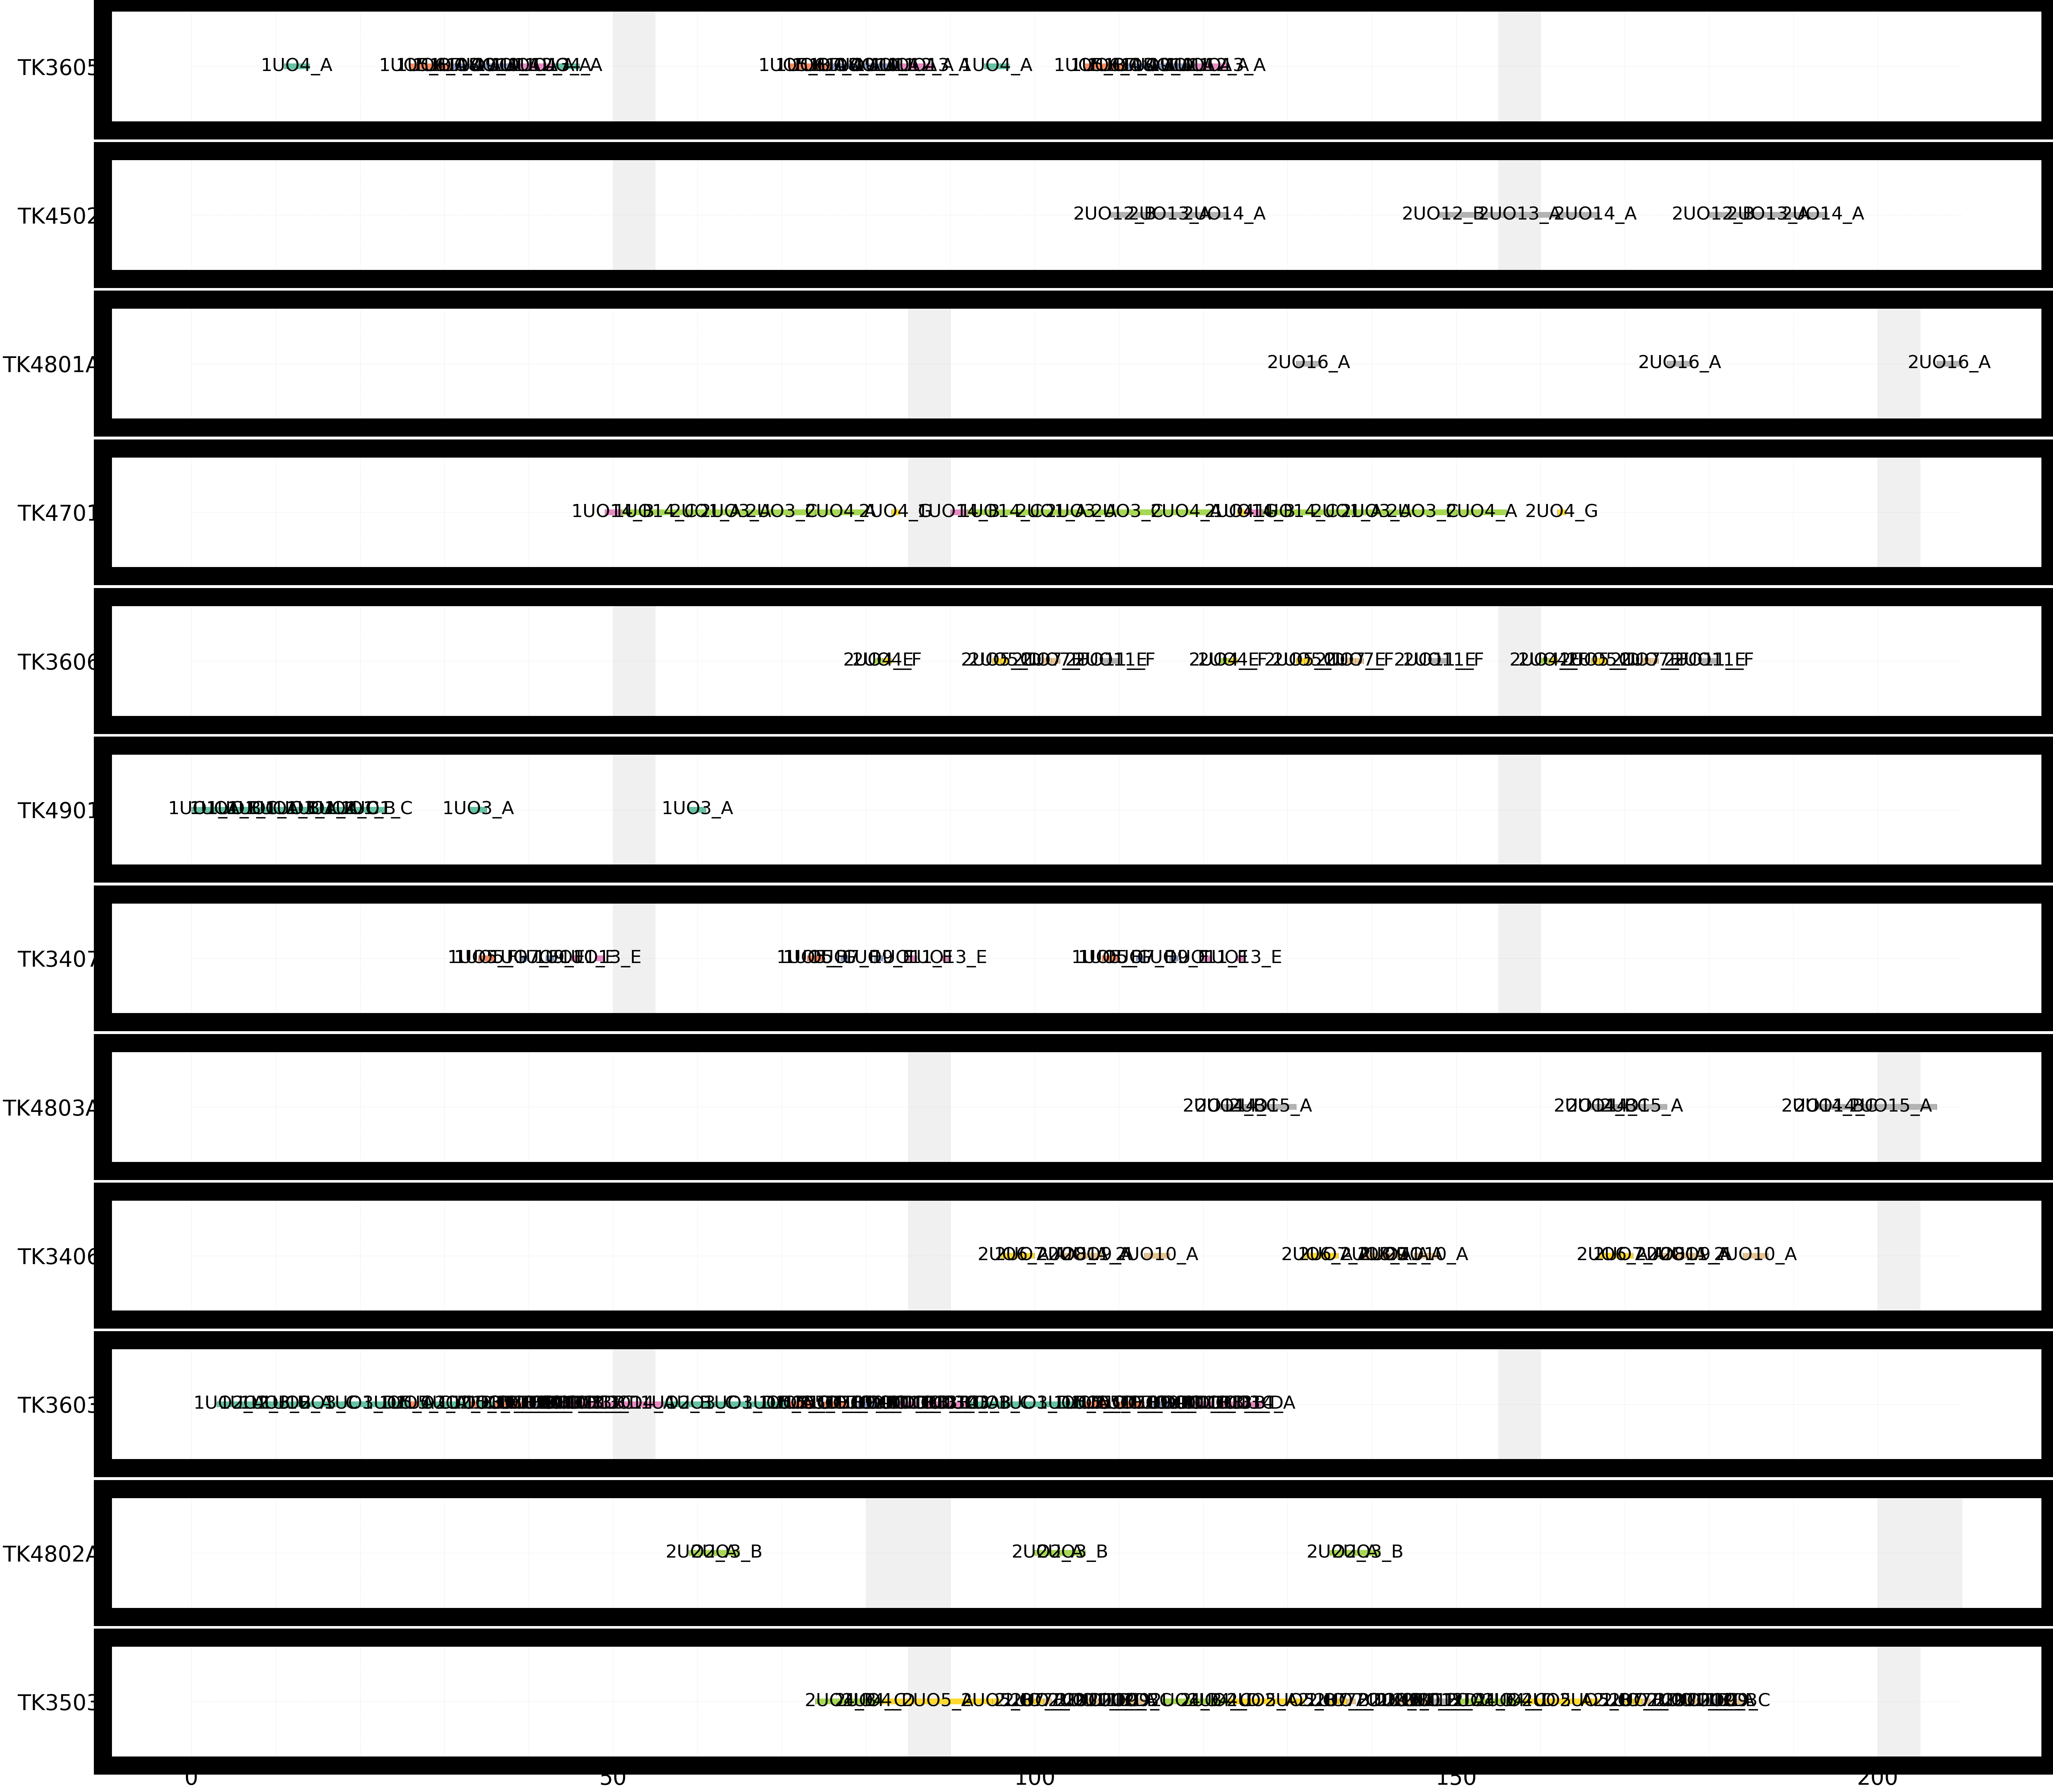

In [84]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
fig = plt.figure()
plt.rcParams['font.size'] = 50
plt.rcParams['figure.figsize'] = 80,70
#plt.rcParams['axes.linewidth']=50
plt.rcParams['ytick.labelsize']=60
plt.rcParams['xtick.labelsize']=60
plt.rcParams['savefig.dpi'] = 100

visu.timeline('Solution SchedCalendar')
for w in TankNames:
    visu.panel()
    visu.pause(Calendar[w])
    visu.sequence(name=w,
                  intervals=[(msol1.get_var_solution(itvs[b,t]), types[t], t) for t in tasks[w] for b in Batches])
plt.savefig('test.png')
visu.show()


In [60]:
msol1.print_solution()

-------------------------------------------------------------------------------
Model constraints: 867, variables: integer: 0, interval: 258, sequence: 12
Solve status: Feasible, Fail status: SearchStoppedByLimit
Search status: SearchStopped, stop cause: SearchStoppedByLimit
Solve time: 8.02 sec
-------------------------------------------------------------------------------
Objective values: (210,), bounds: (127,), gaps: (0.395238,)
0_1UO1_A: (start=14, end=17, size=3, length=3)
0_1UO1_B: (start=19, end=21, size=2, length=2)
0_1UO1_C: (start=21, end=23, size=2, length=2)
0_1UO2_A: (start=27, end=30, size=3, length=3)
0_1UO2_B: (start=30, end=33, size=3, length=3)
0_1UO3_A: (start=33, end=35, size=2, length=2)
0_1UO3_B: (start=34, end=36, size=2, length=2)
0_1UO3_C: (start=59, end=62, size=3, length=3)
0_1UO3_D: (start=62, end=68, size=6, length=6)
0_1UO4_A: (start=43, end=46, size=3, length=3)
0_1UO5_A: (start=68, end=71, size=3, length=3)
0_1UO5_B: (start=71, end=72, size=1, length=1)

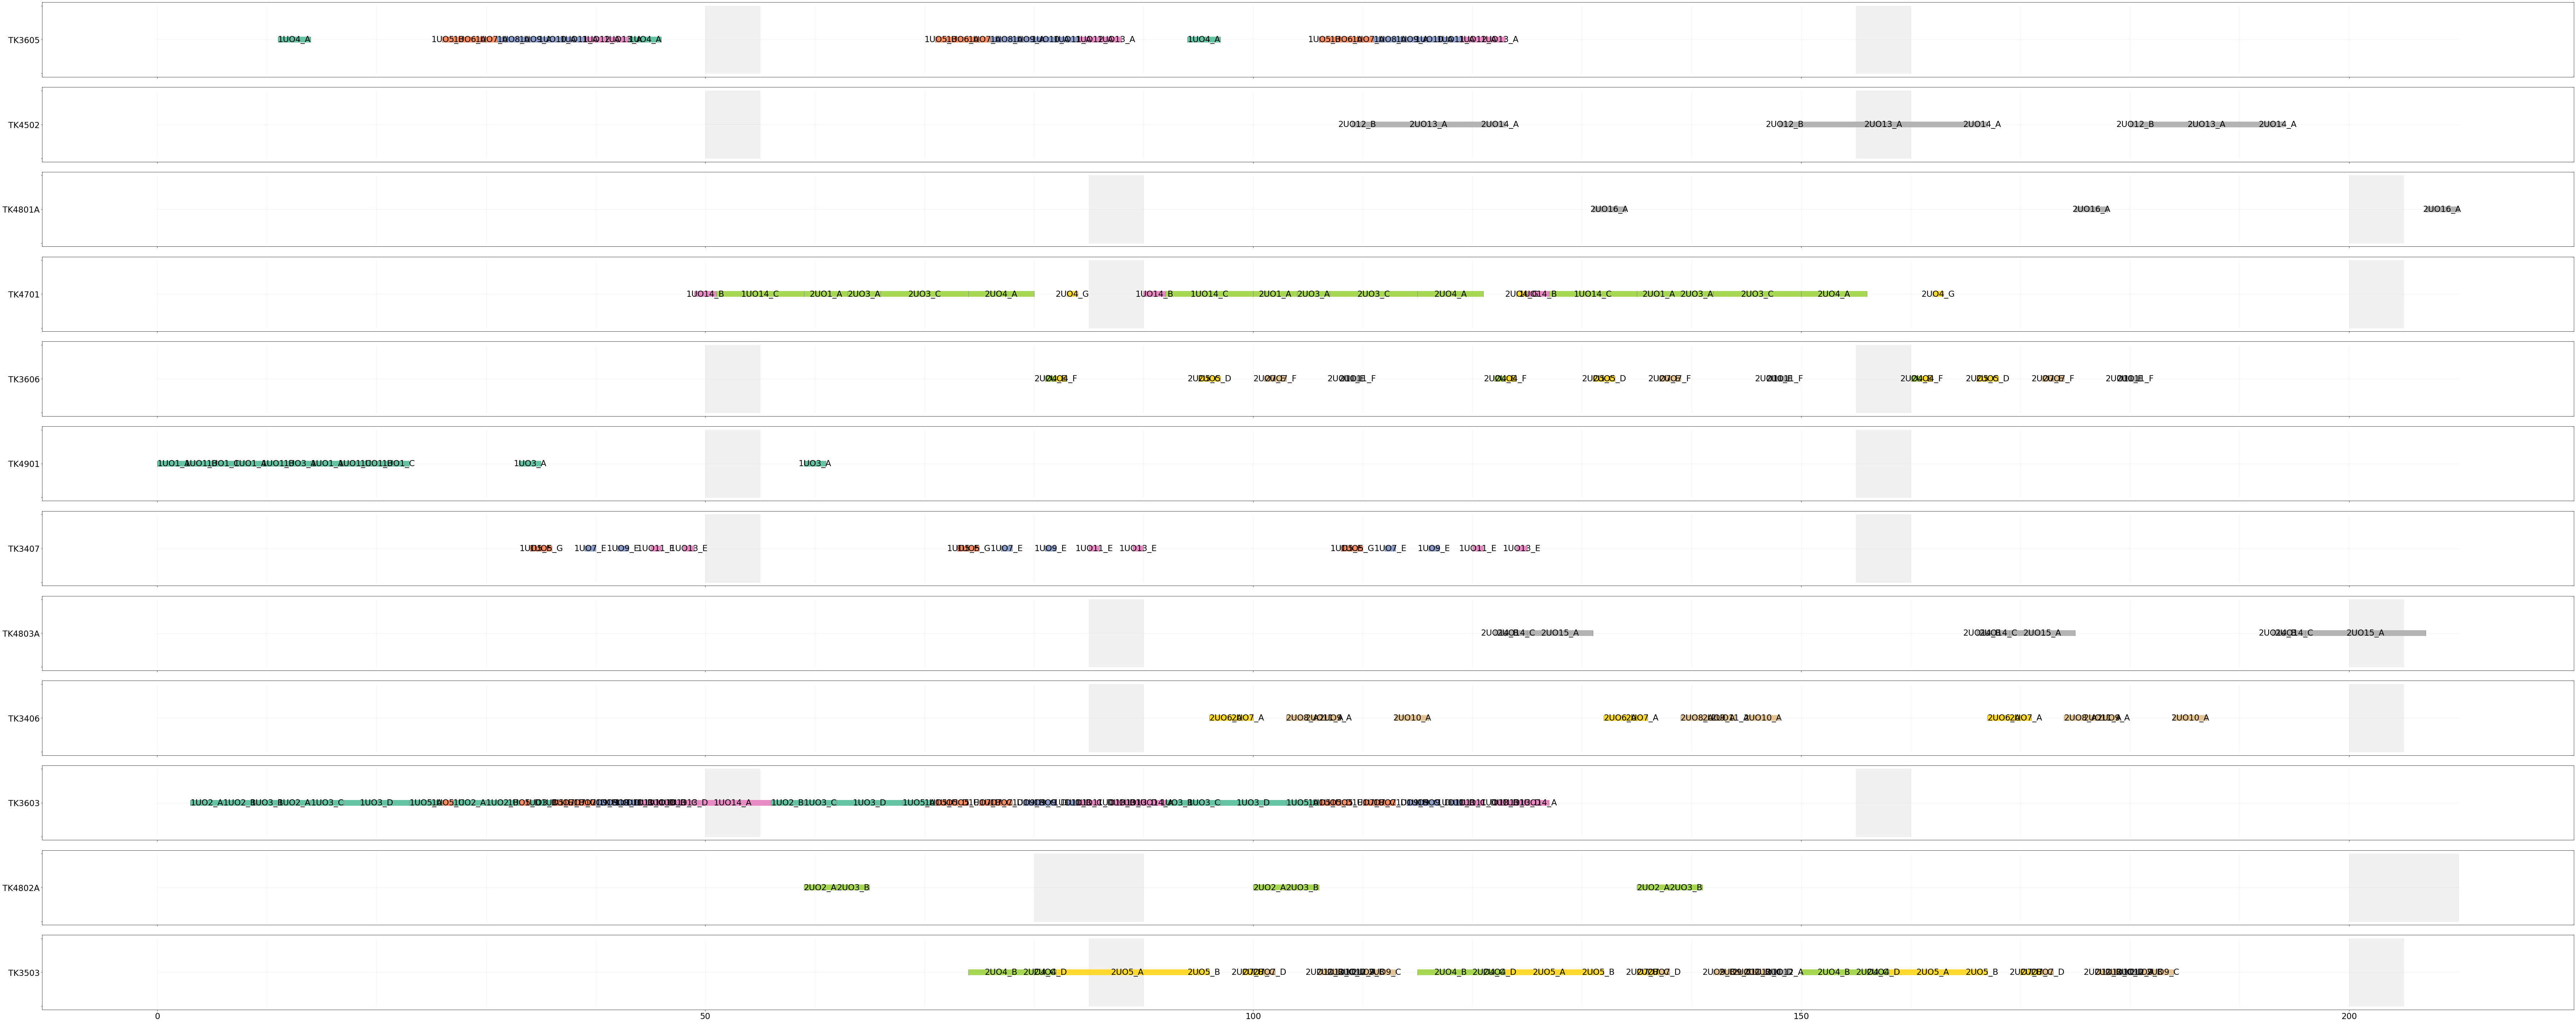

<Figure size 7200x2880 with 0 Axes>

In [52]:
visu.timeline('Solution SchedCalendar')
for w in TankNames:
    visu.panel()
    visu.pause(Calendar[w])
    visu.sequence(name=w,
                  intervals=[(msol1.get_var_solution(itvs[b,t]), types[t], t) for t in tasks[w] for b in Batches])
visu.show()
plt.savefig('test.png')

In [31]:
a = 0
for i in itvs:
    a+=1
    var_sol = [(msol1.get_var_solution(itvs[b,t]), types[t], t) for t in tasks[w] for b in Batches]
    #print("{} : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    print(var_sol[0])
    for k in var_sol:
        #for j in k:
        print("{} : {}..{}".format(str(k[0])[0:12],k[0].get_start(), k[0].get_end()))
print(a)

(<docplex.cp.solution.CpoIntervalVarSolution object at 0x0000025BCD64FF10>, 50, '2UO4_B')
0_2UO4_B: (s : 115..121
1_2UO4_B: (s : 74..80
2_2UO4_B: (s : 150..156
0_2UO4_C: (s : 121..122
1_2UO4_C: (s : 80..81
2_2UO4_C: (s : 156..157
0_2UO4_D: (s : 122..123
1_2UO4_D: (s : 81..82
2_2UO4_D: (s : 157..158
0_2UO5_A: (s : 123..131
1_2UO5_A: (s : 82..95
2_2UO5_A: (s : 158..166
0_2UO5_B: (s : 131..132
1_2UO5_B: (s : 95..96
2_2UO5_B: (s : 166..167
0_2UO7_B: (s : 135..136
1_2UO7_B: (s : 99..100
2_2UO7_B: (s : 170..171
0_2UO7_C: (s : 136..137
1_2UO7_C: (s : 100..101
2_2UO7_C: (s : 171..172
0_2UO7_D: (s : 137..138
1_2UO7_D: (s : 101..102
2_2UO7_D: (s : 172..173
0_2UO9_B: (s : 142..143
1_2UO9_B: (s : 110..111
2_2UO9_B: (s : 181..182
0_2UO9_C: (s : 143..145
1_2UO9_C: (s : 111..113
2_2UO9_C: (s : 182..184
0_2UO11_B: ( : 145..146
1_2UO11_B: ( : 106..107
2_2UO11_B: ( : 177..178
0_2UO11_C: ( : 146..147
1_2UO11_C: ( : 107..108
2_2UO11_C: ( : 178..179
0_2UO11_D: ( : 147..148
1_2UO11_D: ( : 108..109
2_2UO11_D

In [42]:
for i in range(3):
    print('Batch_' + str(i) + '_1UO1_A '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO1_A')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO1_A')]).get_end()))
    print('Batch_' + str(i) + '_1UO1_B '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO1_B')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO1_B')]).get_end()))
    print('Batch_' + str(i) + '_1UO1_C '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO1_C')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO1_C')]).get_end()))
    print('Batch_' + str(i) + '_1UO2_A '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO2_A')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO2_A')]).get_end()))
    print('Batch_' + str(i) + '_1UO2_B '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO2_B')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO2_B')]).get_end()))
    print('Batch_' + str(i) + '_1UO3_A '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_A')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_A')]).get_end()))
    print('Batch_' + str(i) + '_1UO3_B '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_B')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_B')]).get_end()))
    print('Batch_' + str(i) + '_1UO3_C '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_C')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_C')]).get_end()))
    print('Batch_' + str(i) + '_1UO3_D '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_D')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO3_D')]).get_end()))
    print('Batch_' + str(i) + '_1UO4_A '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO4_A')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO4_A')]).get_end()))
    print('Batch_' + str(i) + '_1UO5_A '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_A')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_A')]).get_end()))
    print('Batch_' + str(i) + '_1UO5_B '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_B')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_B')]).get_end()))
    print('Batch_' + str(i) + '_1UO5_C '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_C')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_C')]).get_end()))
    print('Batch_' + str(i) + '_1UO5_D '+'Start: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_D')]).get_start()) + ' End: ' + str(msol1.get_var_solution(itvs[(i, '1UO5_D')]).get_end()))


Batch_0_1UO1_A Start: 14 End: 17
Batch_0_1UO1_B Start: 19 End: 21
Batch_0_1UO1_C Start: 21 End: 23
Batch_0_1UO2_A Start: 27 End: 30
Batch_0_1UO2_B Start: 30 End: 33
Batch_0_1UO3_A Start: 33 End: 35
Batch_0_1UO3_B Start: 34 End: 36
Batch_0_1UO3_C Start: 59 End: 62
Batch_0_1UO3_D Start: 62 End: 68
Batch_0_1UO4_A Start: 43 End: 46
Batch_0_1UO5_A Start: 68 End: 71
Batch_0_1UO5_B Start: 71 End: 72
Batch_0_1UO5_C Start: 71 End: 72
Batch_0_1UO5_D Start: 72 End: 73
Batch_1_1UO1_A Start: 0 End: 3
Batch_1_1UO1_B Start: 3 End: 5
Batch_1_1UO1_C Start: 5 End: 7
Batch_1_1UO2_A Start: 3 End: 6
Batch_1_1UO2_B Start: 6 End: 9
Batch_1_1UO3_A Start: 12 End: 14
Batch_1_1UO3_B Start: 9 End: 11
Batch_1_1UO3_C Start: 14 End: 17
Batch_1_1UO3_D Start: 17 End: 23
Batch_1_1UO4_A Start: 11 End: 14
Batch_1_1UO5_A Start: 23 End: 26
Batch_1_1UO5_B Start: 26 End: 27
Batch_1_1UO5_C Start: 26 End: 27
Batch_1_1UO5_D Start: 33 End: 34
Batch_2_1UO1_A Start: 7 End: 10
Batch_2_1UO1_B Start: 10 End: 12
Batch_2_1UO1_C Start: 

In [33]:
import plotly.figure_factory as ff

date = '2020-01-01'
date1 = '2020-01-02'
date2 = '2020-01-03'

df = [dict(Task="1UO1_A", Start=date+' 00:00', Finish=date+' 03:00',Resource='TK4901'),
    dict(Task="1UO1_B", Start=date+' 03:00', Finish=date+' 05:00',Resource='TK4901'),
    dict(Task="1UO1_C", Start=date+' 05:00', Finish=date+' 07:00',Resource='TK4901'),
     dict(Task="1UO2_A", Start=date+' 03:00', Finish=date+' 06:00',Resource='TK3603'),
     dict(Task="1UO2_B", Start=date+' 06:00', Finish=date+' 09:00',Resource='TK3603'),
     dict(Task="1UO3_A", Start=date+' 10:00', Finish=date+' 12:00',Resource='TK4901'),
     dict(Task="1UO3_B", Start=date+' 09:00', Finish=date+' 11:00',Resource='TK3603'),
     dict(Task="1UO3_C", Start=date+' 14:00', Finish=date+' 09:00',Resource='TK3603'),
     dict(Task="1UO3_D", Start=date+' 17:00', Finish=date+' 23:00',Resource='TK3603'),
     dict(Task="1UO4_A", Start=date+' 11:00', Finish=date+' 14:00',Resource='TK3605'),
     dict(Task="1UO5_A", Start=date+' 23:00', Finish=date1+' 02:00',Resource='TK3603'),
     dict(Task="1UO5_B", Start=date1+' 02:00', Finish=date1+' 03:00',Resource='TK3605'),
     dict(Task="1UO5_C", Start=date1+' 02:00', Finish=date1+' 03:00',Resource='TK3603'),
     dict(Task="1UO5_D", Start=date1+' 03:00', Finish=date1+' 04:00',Resource='TK3603'),
     dict(Task="1UO1_A", Start=date+' 07:00', Finish=date+' 10:00',Resource='TK4901'),
    dict(Task="1UO1_B", Start=date+' 12:00', Finish=date+' 14:00',Resource='TK4901'),
    dict(Task="1UO1_C", Start=date+' 14:00', Finish=date+' 16:00',Resource='TK4901'),
     dict(Task="1UO2_A", Start=date+' 11:00', Finish=date+' 14:00',Resource='TK3603'),
     dict(Task="1UO2_B", Start=date1+' 05:00', Finish=date1+' 08:00',Resource='TK3603'),
     dict(Task="1UO3_A", Start=date1+' 08:00', Finish=date1+' 11:00',Resource='TK4901'),
     dict(Task="1UO3_B", Start=date1+' 17:00', Finish=date1+' 19:00',Resource='TK3603'),
     dict(Task="1UO3_C", Start=date1+' 22:00', Finish=date2+' 01:00',Resource='TK3603'),
     dict(Task="1UO3_D", Start=date2+' 01:00', Finish=date2+' 07:00',Resource='TK3603'),
     dict(Task="1UO4_A", Start=date1+' 19:00', Finish=date1+' 22:00',Resource='TK3605'),
     dict(Task="1UO5_A", Start=date2+' 07:00', Finish=date2+' 10:00',Resource='TK3603'),
     dict(Task="1UO5_B", Start=date2+' 10:00', Finish=date2+' 11:00',Resource='TK3605'),
     dict(Task="1UO5_C", Start=date2+' 10:00', Finish=date2+' 11:00',Resource='TK3603'),
     dict(Task="1UO5_D", Start=date2+' 11:00', Finish=date2+' 12:00',Resource='TK3603')
     ]

fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True,group_tasks=True)
fig.show()

In [68]:
print(len(TaskNames))
from datetime import datetime

date = datetime.strptime('01 01 2020', '%d %m %Y')
#newdate = date.replace(hour=11, minute=59)
dictList = list()
for k in range(NbBatches):
    
    for i in range(len(TaskNames)):
        date = datetime.strptime('01 01 2020', '%d %m %Y')
        if msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start() > 24:
            day = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start()/24)
            hour = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start()%24)
            startdate = date.replace(day = day, hour=hour)
        else:
            startdate = date.replace(hour=msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start())
        
        if msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end() > 24:
            day = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end()/24)
            hour = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end()%24)
            enddate = date.replace(day = day, hour=hour)
        else:
            enddate = date.replace(hour=msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end())    
            
        
        dictList.append(dict(Task=TaskNames[i], Start=startdate, Finish=enddate, Batch = k+1, Resource=Tanks[TaskNames[i]]))

86


In [69]:
data = pd.DataFrame(dictList)
import plotly.figure_factory as ff


fig = ff.create_gantt(dictList, group_tasks=True)
fig.show()